# Unit Commitment Economic Dispatch (UCED)

This notebook was adapted from Jesse D. Jenkins and Michael R. Davidson to use Python instead of Julia. The original notebook can be found here: https://github.com/Power-Systems-Optimization-Course/power-systems-optimization/blob/master/Notebooks/05-Unit-Commitment.ipynb.

This notebook will illustrate how to optimize the economic dispatch of power generators while accounting for binary startup (called "commitment") decisions, constraints, and costs of thermal generators. The goal is to minimize the short-run production costs of meeting electricity demand, subject to the constraints of operating systems with large amounts of (inflexible) thermal generation. Accounting for these commitment (binary variable) constraints requires significant computational trade-offs.

*****

We build up the model in several stages. We first start with the simplest model that incorporates unit commitment decisions in order to understand the logic of three-variable commitment formulations.

Next, we introduce moderate complexity through the addition of ramp constraints to account for startups and shutdowns.

Finally, we model a more realistic unit commitment that includes reserves&mdash;an important feature of day-ahead scheduling in power systems.

## Introduction to unit commitment

Engineering considerations severely limit the possible output ranges of power plants. System operators need to be aware of these limitations when scheduling generation to meet demand. Thermal power plants, in particular, due to their complex designs, thermodynamic cycles, and material properties, can be particularly challenging. In practice, due to the times involved in bringing these power plants online, much of this scheduling is done day-ahead, which gives rise to the need for a day-ahead market.

**Unit commitment economic dispatch** (UCED) is the problem of minimizing short-run costs of production inclusive of production and startup costs, in order to meet a given demand and considering relevant engineering constraints of the generators. This notebook, for simplicity, only considers a single-bus case, while typical formulations usually include a simplified network representation.

## Simple unit commitment

We start with the simplest case that incorporates unit commitment.


$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} + \sum_{g \in G_{thermal}, t \in T} StartUpCost_g \times START_{g,t} \\
\end{align}
$$
$$
\begin{align}
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & COMMIT_{g,t} \geq \sum_{t'≥t-MinUp_g}^{t} START_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & 1-COMMIT_{g,t} \geq \sum_{t'≥t-MinDown_g}^{t} SHUT_{g,t} &\forall \quad g \in G_{thermal} , t \in T \\
  & COMMIT_{g,t+1} - COMMIT_{g,t} =&\\
 & \quad START_{g,t+1} - SHUT_{g,t+1} &\forall \quad G_{thermal} \in G , t = 1..T-1
\end{align}
$$


The **decision variables** in the above problem:

- $GEN_{g}$, generation (in MW) produced by each generator, $g$
- $START_{g,t}$, startup decision (binary) of thermal generator $g$ at time $t$
- $SHUT_{g,t}$, shutdown decision (binary) of thermal generator $g$ at time $t$
- $COMMIT_{g,t}$, commitment status (binary) of generator $g$ at time $t$

The **parameters** are:

- $Pmin_g$, the minimum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Pmax_g$, the maximum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Demand$, the demand (in MW)
- $VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g$, the variable cost of generator $g$
- $StartUpCost_g$, the startup cost of generator $g$
- $MinUp_g$, the minimum up time of generator $g$, or the minimum time after start-up before a unit can shut down
- $MinDown_g$, the minimum down time of generator $g$, or the minimum time after shut-down before a unit can start again

In addition, we introduce a few different sets:

- $G$, the set of all generators
- $G_{thermal} \subset G$, the subset of thermal generators for which commitment is necessary
- $T$, the set of all time periods over which we are optimizing commitment and dispatch decisions

Finally, the **three-variable commitment equations** capture the basic logic of commitment:

- Units incur costs when they startup (not when they shutdown)
- Units must stay on (and off) for a minimum period of time&mdash;in lieu of explicitly enforcing a startup trajectory
- Some summations (simplified here) will need to be modified near the beginning of the time period

There are some further resources at the bottom for alternative and/or more complex formulations of the UCED problem.

Let's implement this version.

### 1. Load packages

First, let's install and load the Python packages we'll need to work with here.

In [ ]:
!pip install gurobipy

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# allow access to google drive
drive.mount('/content/drive')

### 2. Load and format data

We will use data loosely based on San Diego Gas and Electric (SDG&E, via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform) including a few neighboring generators and adjustments to make the problem easy to solve, consisting of:

- 33 generators (we added a few more to ensure we can provide enough reserves)
- estimated hourly demand for 2020 (net load at the transmission substation level after subtracting 600MW of behind-the-meter solar from original demand)
- variable generation capacity factors
- estimated natural gas fuel costs

In order to demonstrate the impacts of unit commitment, we will use a high solar sensitivity case with 3,500 MW of solar PV to produce large variations in net load required to meet demand (similar to [California's infamous "Duck Curve"](https://www.caiso.com/Documents/FlexibleResourcesHelpRenewables_FastFacts.pdf)).

In [ ]:
datadir = "drive/MyDrive/Colab Notebooks/UCED_data/"
gen_info = pd.read_csv(datadir + "Generators_data.csv")
fuels = pd.read_csv(datadir + "Fuels_data.csv")
loads = pd.read_csv(datadir + "Demand.csv")
gen_variable = pd.read_csv(datadir + "Generators_capacity_factors.csv")

Look at the data

In [ ]:
gen_info.columns.values

In [ ]:
fuels

In [ ]:
loads.columns.values

In [ ]:
gen_variable.columns.values

**Construct generator dataframe**

In [ ]:
# Keep columns relevant to our UCED model
gen_info = gen_info.iloc[:,0:26] # first 26 columns
gen_df = gen_info.join(fuels.set_index("Fuel"), on="Fuel")
gen_df.rename(columns={"Cost_per_MMBtu": "Fuel_cost"},inplace=True)
gen_df["Fuel_cost"].fillna(0) # replace NAs for fuel cost with 0

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df["Is_variable"] = False
indices = [i for i in gen_df.index if gen_df["Resource"][i] in ["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]]
gen_df["Is_variable"].iloc[indices] = True

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df["Gen_full"] = gen_df["region"] + "_" + gen_df["Resource"] + "_" + gen_df["cluster"].astype("str") + ".0"

# remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df["Existing_Cap_MW"] > 0]

gen_df

**Modify load and variable generation dataframes**

In [ ]:
# 1. Convert from GMT to GMT-8
gen_variable["Hour"] = np.mod(gen_variable["Hour"]-9, 8760)
gen_variable = gen_variable.sort_values(by="Hour")
loads["Hour"] = np.mod(loads["Hour"]-9, 8760)
loads = loads.sort_values(by="Hour")
loads.set_index("Hour",inplace=True)
gen_variable.set_index("Hour",inplace=True)
gen_variable

In [ ]:
# convert gen_variables to H x G data frame of hourly capacity factors at each generator in gen_df
# this is so we can reference it by indices in the optimization that correspond to the indices in gen_df
capacity_factors = pd.DataFrame()
for source in gen_df["Gen_full"]:
  if source in gen_variable.columns.values:
    capacity_factors[source] = gen_variable[source]
  else:
    capacity_factors[source] = "NA"

capacity_factors

### 3. Setup problem: Solve unit commitment for a spring day with high solar (day 100)

In [ ]:
# A spring day
n=100
T_period = np.arange(n*24,(n+1)*24)

# High solar case: 3,500 MW
gen_df_sens = gen_df.copy()
gen_df_sens["Existing_Cap_MW"][np.where(gen_df_sens["Resource"] == "solar_photovoltaic")[0]]= 3500

# Note we reduce the MIP gap tolerance threshold here to increase tractability
# Here we set it to a 1% gap (mip_gap=0.01), meaning that we will terminate once we have
# a feasible integer solution guaranteed to be within 1% of the objective
# function value of the optimal solution (e.g. the upper and lower bound are within 1% of
# each other as Gurobi traverses the branch and bound tree).
# Gurobi's default MIP gap is 0.0001 (0.01%), which can take a longer time for
# any complex problem. So it is important to set this to a realistic value.
mip_gap = 0.0001

In [ ]:
# create environment with Gurobi academic license
# CHANGE THESE TO THE VALUES FOR YOUR LICENSE
params = {
"WLSACCESSID": '69c0357e-257d-4855-a3f0-446b8e822abd',
"WLSSECRET": '11082e14-04a8-4439-a62d-f3acd3d46920',
"LICENSEID": 2471772,
}
env = gp.Env(params=params)

Define sets of all generators (thermal, non-thermal, variable, non-variable, non-variable and non-thermal) and hours

In [ ]:
UCED = gp.Model('UCED model', env=env)
UCED.Params.MIPGap = mip_gap

# Define sets based on data
# Note the creation of several different sets of generators for use in
# different equations.
# Thermal resources for which unit commitment constraints apply
G_thermal = gen_df_sens.index[np.where(gen_df_sens["Up_time"] > 0)[0]]

# Non-thermal resources for which unit commitment constraints do NOT apply
G_nonthermal = gen_df_sens.index[np.where(gen_df_sens["Up_time"] == 0)[0]]

# Variable renewable resources
G_var = gen_df_sens.index[np.where(gen_df_sens["Is_variable"] == 1)[0]]

# Non-variable (dispatchable) resources
G_nonvar = gen_df_sens.index[np.where(gen_df_sens["Is_variable"] == 0)[0]]

# Non-variable and non-thermal resources
G_nonthermal_nonvar = np.intersect1d(G_nonvar, G_nonthermal)

# Set of all generators (above are all subsets of this)
G = gen_df_sens.index

# All time periods (hours) over which we are optimizing
H = loads.index[loads.index.isin(T_period)]

# A subset of time periods that excludes the last time period
H_red = H[0:-1]  # reduced time periods without last one

Define decision variables:
* generation at each generator each hour
* commitment at each thermal generator (whether it is on or off each hour)
* whether a thermal generator is turned on each hour
* whether a thermal generator is shut off each hour

In [ ]:
# Decision variables
GEN = UCED.addVars(len(G), len(H), vtype=GRB.CONTINUOUS, name="GEN")
COMMIT = UCED.addVars(len(G_thermal), len(H), vtype=GRB.BINARY, name="COMMIT")
START = UCED.addVars(len(G_thermal), len(H), vtype=GRB.BINARY, name="START")
SHUT = UCED.addVars(len(G_thermal), len(H), vtype=GRB.BINARY, name = "SHUT")

Define constraints:
1. Total generation across generators = demand every hour

In [ ]:
# non-negativity constraints assumed, just add demand, capacity and unit commitment constraints
# demand constraint
c1_demand = UCED.addConstrs((gp.quicksum(GEN[g,h-H[0]] for g in G) == loads["Demand"].iloc[loads.index==h])
                                     for h in H)

2. Thermal generators must generator at least the minimum power and no more than their capacity

In [ ]:
# capacity constraints
# 1. thermal generators requiring commitment
c2_min_thermal = UCED.addConstrs(GEN[g,h-H[0]] >= COMMIT[g-G_thermal[0],h-H[0]] * gen_df_sens["Existing_Cap_MW"].iloc[g] * gen_df_sens["Min_power"].iloc[g]
                                  for g in G_thermal
                                  for h in H)
c3_max_thermal = UCED.addConstrs(GEN[g,h-H[0]] <= COMMIT[g-G_thermal[0],h-H[0]] * gen_df_sens["Existing_Cap_MW"].iloc[g]
                                  for g in G_thermal
                                  for h in H)

3. Non-thermal, non-variable generators cannot generator more than their capacity each hour, and non-thermal, variable generators cannot generate more than their capacity factor * capacity each hour

In [ ]:
# 2. non-variable generation not requiring commitment
c4_nonthermal_nonvar = UCED.addConstrs(GEN[g,h-H[0]] <= gen_df_sens["Existing_Cap_MW"].iloc[g]
                                  for g in G_nonthermal_nonvar
                                  for h in H)

# 3. variable generation, accounting for hourly capacity factor
c5_variable = UCED.addConstrs(GEN[g,h-H[0]] <= capacity_factors.iloc[h,g] * gen_df_sens["Existing_Cap_MW"].iloc[g]
                              for g in G_var
                              for h in H)

4. Unit commitment constraints: cannot start up if down time has not been exceeded, cannot turn off if time on has not been exceeded.

In [ ]:
# unit commitment constraints
# 1. Minimum up time
c6_min_up_time = UCED.addConstrs(COMMIT[g-G_thermal[0],h-H[0]] >=
                                 gp.quicksum(START[g-G_thermal[0],hh-H[0]] for hh in np.intersect1d(H,range(h-gen_df_sens["Up_time"].iloc[g],h)))
                                  for g in G_thermal
                                 for h in H)

# 2. Minimum down time
c7_min_down_time = UCED.addConstrs(1-COMMIT[g-G_thermal[0],h-H[0]] >=
                                 gp.quicksum(SHUT[g-G_thermal[0],hh-H[0]] for hh in np.intersect1d(H, range(h-gen_df_sens["Down_time"].iloc[g],h)))
                                  for g in G_thermal
                                 for h in H)

# 3. Commitment state
c8_commitment_status = UCED.addConstrs(COMMIT[g-G_thermal[0],h-H[0]+1] - COMMIT[g-G_thermal[0],h-H[0]] ==
                                       START[g-G_thermal[0],h-H[0]+1] - SHUT[g-G_thermal[0],h-H[0]+1]
                                  for g in G_thermal
                                  for h in H_red)

Define objective function: minimize costs of variable generation, non-variable generation, and startup at thermal generators

In [ ]:
# Objective function
# Sum of variable costs + start-up costs for all generators and time periods
cost_nonvar_gen = gp.quicksum(
    gp.quicksum(GEN[g,h-H[0]] * (gen_df_sens["Var_OM_cost_per_MWh"].iloc[g] +
                                   gen_df_sens["Heat_rate_MMBTU_per_MWh"].iloc[g] * gen_df_sens["Fuel_cost"].iloc[g])
    for h in H)
  for g in G_nonvar
)

cost_var_gen = gp.quicksum(gp.quicksum(gen_df_sens["Var_OM_cost_per_MWh"].iloc[g] * GEN[g,h-H[0]]
    for g in G_var
    )
  for h in H
)

cost_startup = gp.quicksum(gen_df_sens["Start_cost_per_MW"].iloc[g] * gen_df_sens["Existing_Cap_MW"].iloc[g] * START[g-G_thermal[0],h-H[0]]
    for g in G_thermal
    for h in H)

UCED.setObjective(cost_nonvar_gen + cost_var_gen + cost_startup)

Run optimization

In [ ]:
UCED.optimize()

Summarize output in data frames with binary commitment decisions at each generator each hour, total generation at each generator each hour, and total curtailment of variable generators each hour.

In [ ]:
rows = ["Hour" + str(h) for h in H]
commit = pd.DataFrame(columns=gen_df_sens["Gen_full"].loc[G_thermal], index=rows, data=0.0)
for h in H:
    for g in G_thermal:
        commit.loc["Hour"+str(h), gen_df_sens["Gen_full"].loc[g]] = COMMIT[g-G_thermal[0],h-H[0]].x

In [ ]:
rows = ["Hour" + str(h) for h in H]
gen = pd.DataFrame(columns=gen_df_sens["Gen_full"], index=rows, data=0.0)
for h in H:
    for g in G:
        gen.loc["Hour"+str(h), gen_df_sens["Gen_full"].iloc[g]] = GEN[g,h-H[0]].x

In [ ]:
# calculate curtailment
curtail = np.zeros([len(H),len(G_var)])
for g in G_var:
  for h in H:
    curtail[h-H[0],g-G_var[0]] = capacity_factors.iloc[h,g] * gen_df_sens["Existing_Cap_MW"].iloc[g] - GEN[g,h-H[0]].x

curtail = pd.DataFrame(curtail, columns=capacity_factors.iloc[:,G_var].columns.values)
curtail.set_index(gen.index,inplace=True)

Plot a stacked bar chart of generation from each generator each hour

In [ ]:
CCGT = [col for col in gen.columns.values if "combined" in col]
CT = [col for col in gen.columns.values if "combustion" in col]

btm = gen_variable["WEC_SDGE_solar_photovoltaic_1.0"].iloc[H]*600
btm = btm.to_frame()
btm.set_index(gen.index,inplace=True)

gen_by_type = pd.DataFrame({"Natural Gas CT": gen[CT].sum(axis=1), "Natural Gas CCGT": gen[CCGT].sum(axis=1),
                            "Hydro PSH": gen['WEC_SDGE_hydroelectric_pumped_storage_1.0'], "Biomass": gen['WEC_SDGE_biomass_1.0'],
                            "Solar PV": gen['WEC_SDGE_solar_photovoltaic_1.0'], "Small Hydro": gen['WEC_SDGE_small_hydroelectric_1.0'],
                            "Onshore Wind": gen['WEC_SDGE_onshore_wind_turbine_1.0'],"Curtailment": curtail.sum(axis=1),
                            "Solar BTM": btm["WEC_SDGE_solar_photovoltaic_1.0"]})
loads = loads.iloc[H].set_index(gen.index)
gen_by_type["Demand"] = loads["Demand"]
gen_by_type["Hour"] = gen_by_type.index.astype('string')
gen_by_type

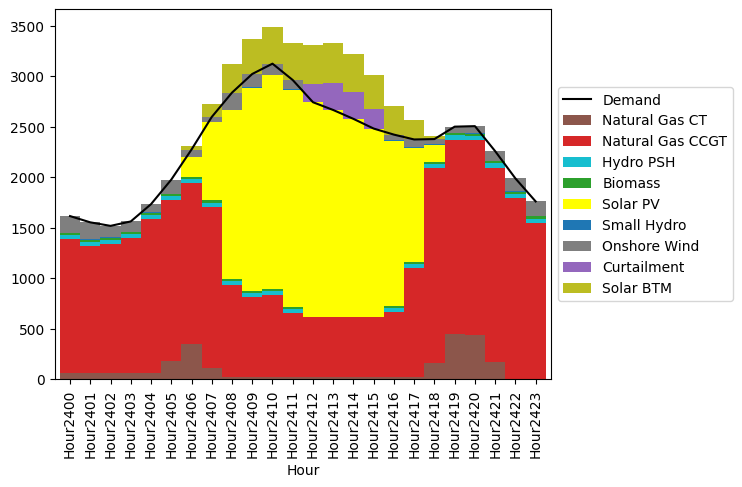

In [ ]:
cols_to_plot = ["Hour", "Natural Gas CT", "Natural Gas CCGT", "Hydro PSH", "Biomass", "Solar PV", "Small Hydro", "Onshore Wind", "Curtailment",	"Solar BTM"]
ax = gen_by_type[["Hour", "Demand"]].plot(x="Hour",color="black")
gen_by_type[cols_to_plot].plot(x="Hour",kind="bar", stacked=True, width=1, color=["tab:brown","tab:red","tab:cyan","tab:green","yellow",
                                                   "tab:blue","tab:gray","tab:purple","tab:olive"], ax=ax).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Plot a stacked bar chart of commitment decisions at thermal generators each hour.

Notice that the combined cycle plants flatten out during the day, but don't shut down due to the need for ramping capabilities in the late afternoon/evening, when solar output falls off and evening demand remains strong. This leads to some curtailment of solar from 11:00 - 16:00. All curtailment is lumped together as the model does not accurately distinguish between whether wind, solar or hydro is curtailed, which in practice is up to the system operator and depends on a variety of factors such as location, interconnection voltage, etc.

In [ ]:
commit_by_type = pd.DataFrame({"Natural Gas CT": commit[CT].sum(axis=1), "Natural Gas CCGT": commit[CCGT].sum(axis=1)})
commit_by_type

In [ ]:
commit_by_type.plot.bar(stacked=True, width=1, color=["tab:orange","tab:blue"])

Note that units shutdown during the solar period and startup for the evening peak. However, due to the commitment constraints, not all natural gas plants can be decommitted, resulting in the observed curtailment. A large number of combustion turbines turn on to meet the evening peak.

### Further resources

Knueven, B., Ostrowski, J., & Watson, J.-P. (2019). On Mixed Integer Programming Formulations for the Unit Commitment Problem. Optimization Online, 91. http://www.optimization-online.org/DB_FILE/2018/11/6930.pdf

Morales-Espana, G., Latorre, J. M., & Ramos, A. (2013). Tight and Compact MILP Formulation of Start-Up and Shut-Down Ramping in Unit Commitment. IEEE Transactions on Power Systems, 28(2), 1288–1296. https://doi.org/10.1109/TPWRS.2012.2222938

Morales-España, G., Ramírez-Elizondo, L., & Hobbs, B. F. (2017). Hidden power system inflexibilities imposed by traditional unit commitment formulations. Applied Energy, 191, 223–238. https://doi.org/10.1016/j.apenergy.2017.01.089

Ostrowski, J., Anjos, M. F., & Vannelli, A. (2012). Tight Mixed Integer Linear Programming Formulations for the Unit Commitment Problem. IEEE Transactions on Power Systems, 27(1), 39–46. https://doi.org/10.1109/TPWRS.2011.2162008